## Part 1: preparing data

Load pixel data from CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


img_size = 28
mnist_data = pd.read_csv('./mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]      # DATA: raw digits data

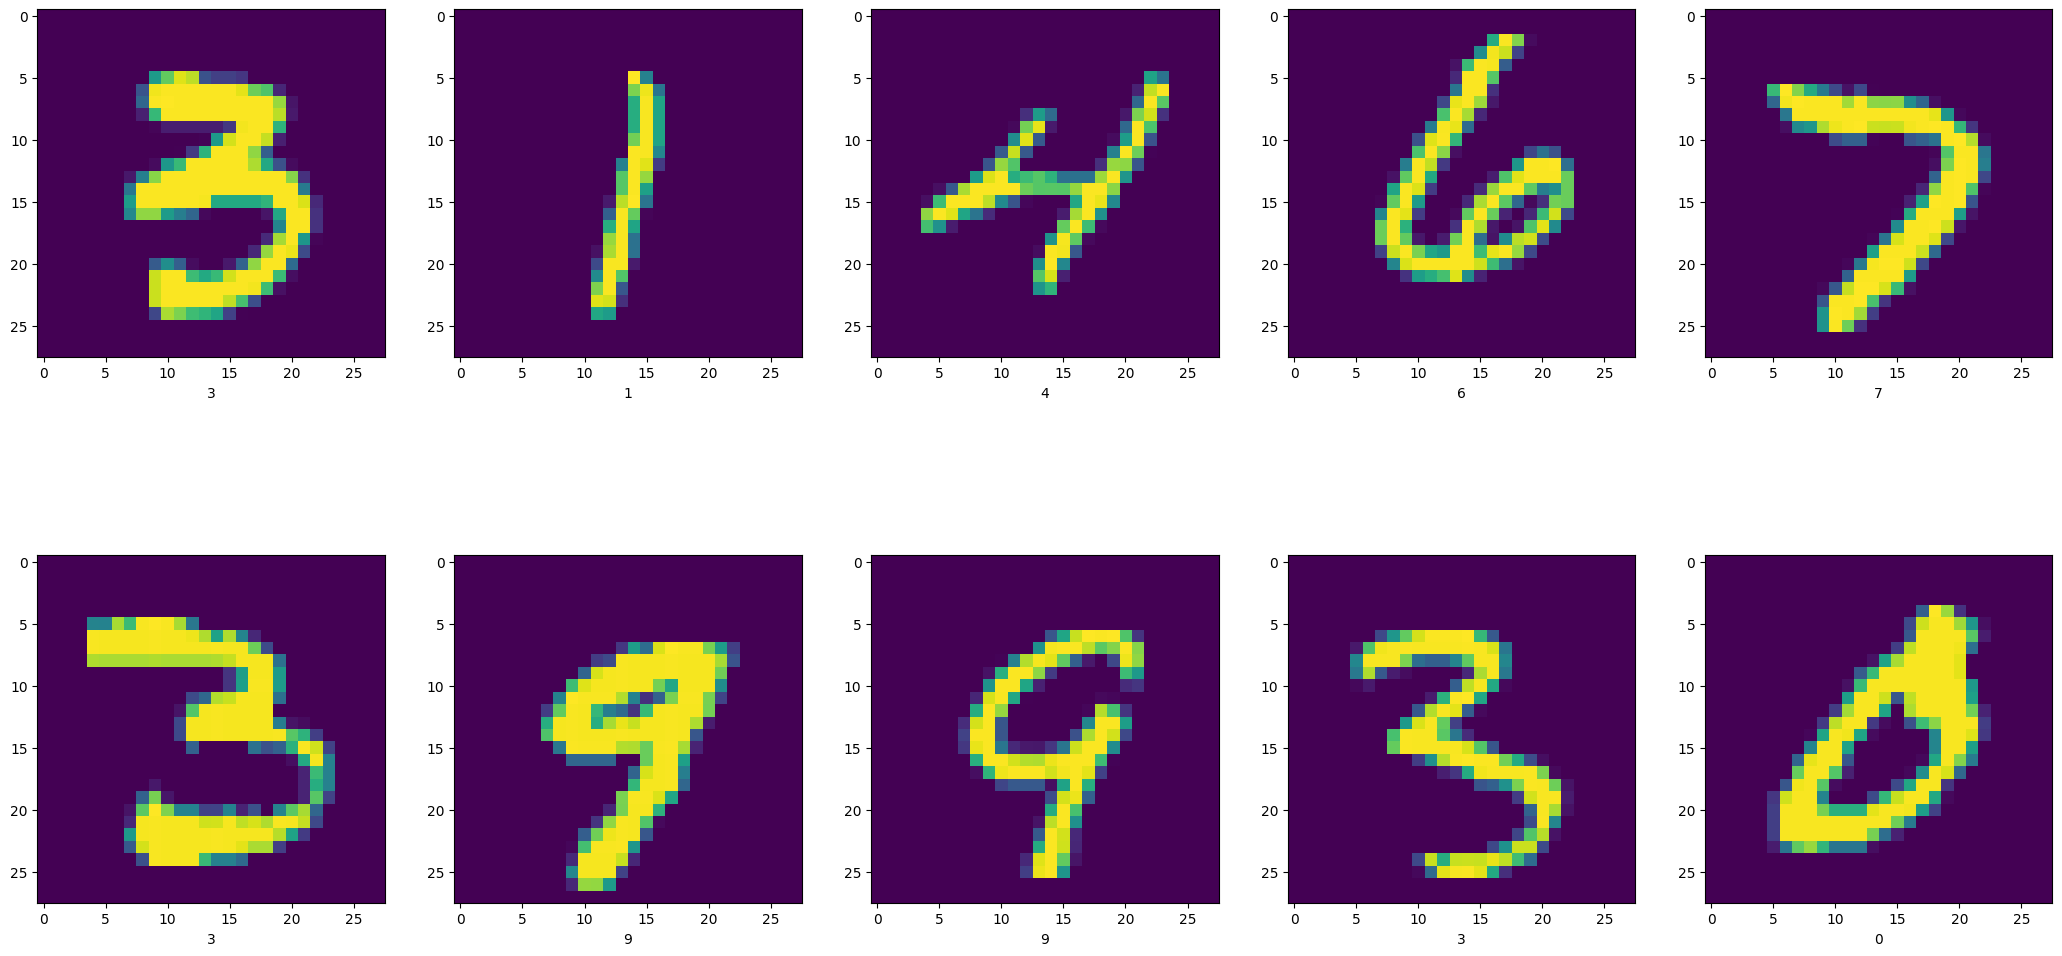

In [17]:
# Visually sampling the data

img_size = 28
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digits))
    plt.imshow(digits[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Resizing the image

After multiple attempts at fitting the model, it was observed that the required time for the model to converge was too expensive (in one instance, it does not converge even after 2 hours). Hence it was decided to resize the number of features down to 196 (14 x 14 pixel image).

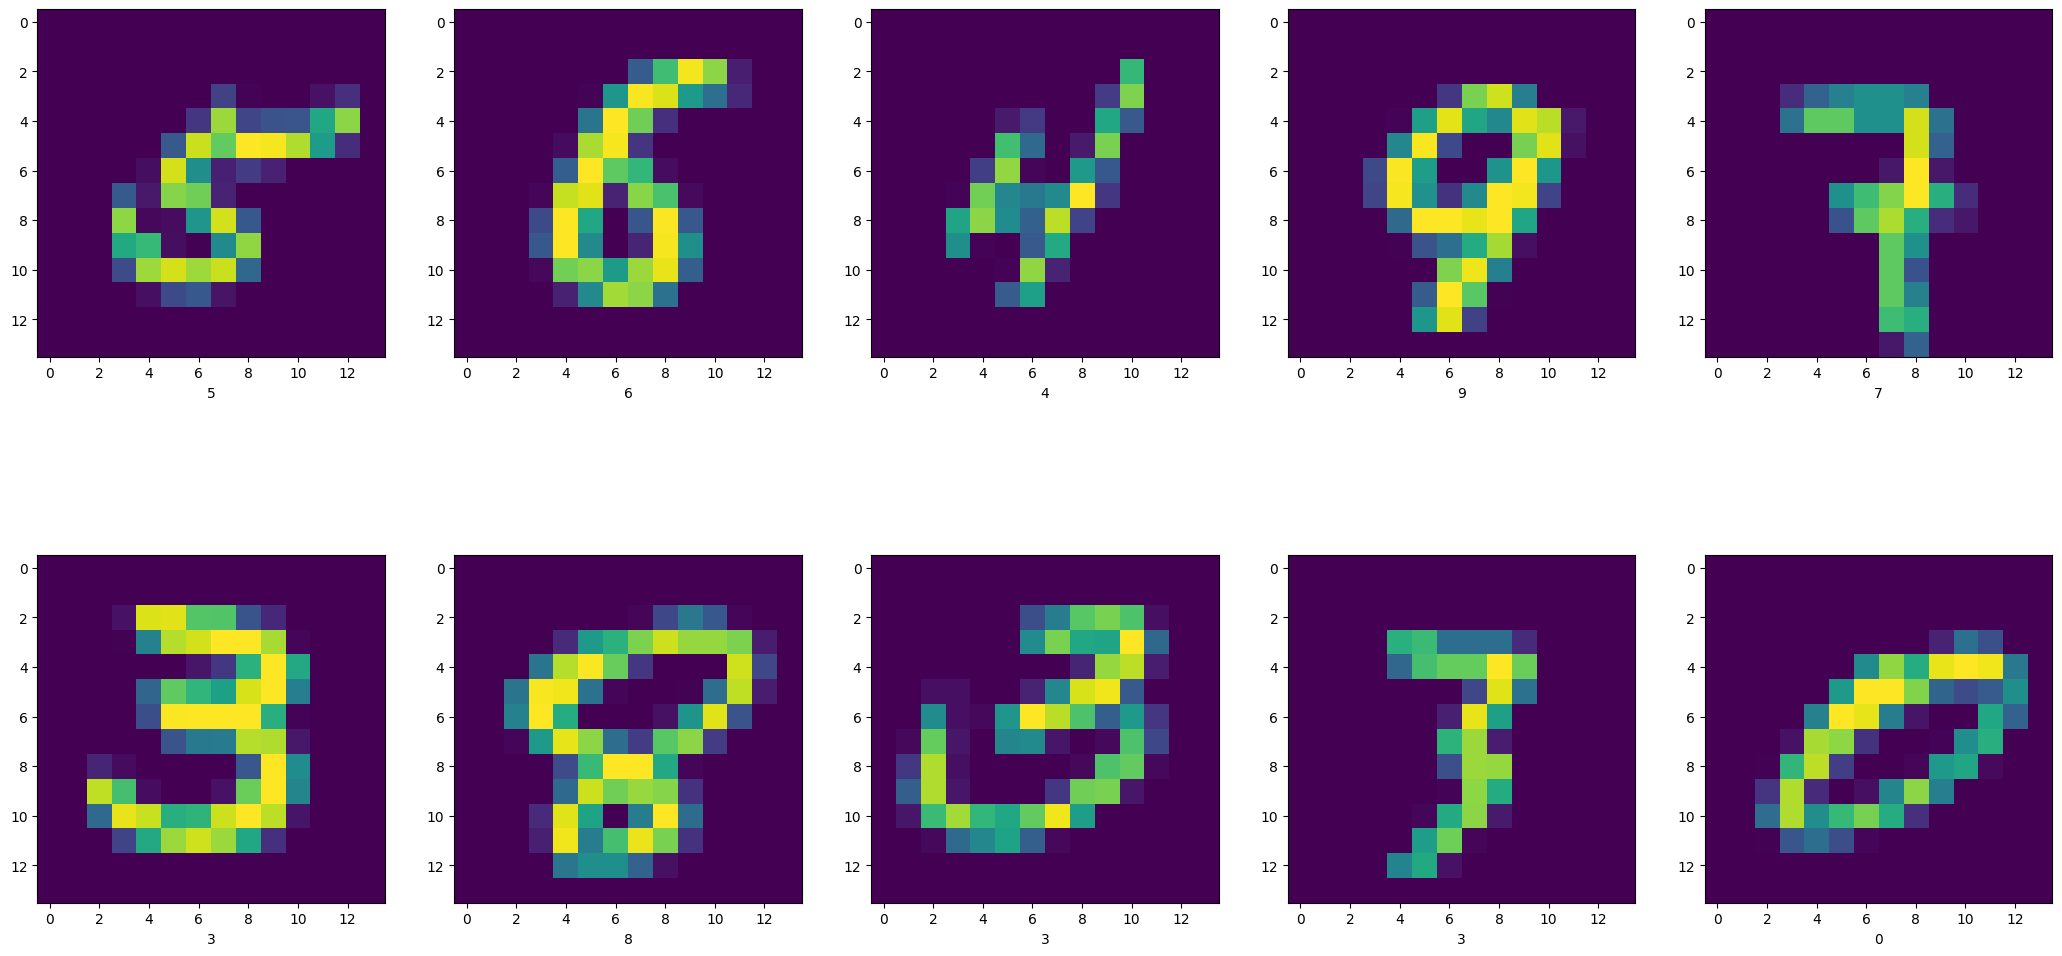

#### Splitting and scaling dataset

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    digitsFiltered, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train0_std = scaler.fit_transform(X_train0)       # Digits, filtered and scaled.
X_test0_std = scaler.transform(X_test0)


scaler = StandardScaler()
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    digitsResized, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train1_std = scaler.fit_transform(X_train1)       # Digits, resized and scaled.
X_test1_std = scaler.transform(X_test1)


scaler = StandardScaler()
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    digitsResizedFiltered, 
    labels, 
    train_size=5000,
    test_size=37000, 
    random_state=1
)
X_train2_std = scaler.fit_transform(X_train2)       # Digits, resized filtered and scaled.
X_test2_std = scaler.transform(X_test2)

#### End of part 1

We have prepared 3 sets of data:
- Set 0 has its constant features removed.
- Set 1 has its image dimension reduced by half.
- Set 2 has both treatments from set 0 and 1.

All sets are scaled. We are going to work mainly with set 2. Other sets are supplementary.

## Part 2: SVM parameter tuning using grid search

We are going to tune the parameters for SVC with polynomial, linear, and RBF kernels.

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.840 total time=   8.7s
[CV 2/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.880 total time=   5.7s
[CV 3/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.846 total time=   2.5s
[CV 4/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.858 total time=   2.7s
[CV 5/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.848 total time=   2.9s
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.114 total time=   3.6s
[CV 2/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.115 total time=   3.5s
[CV 3/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.115 total time=   3.2s
[CV 4/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.114 total time=   4.0s
[CV 5/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.114 total time=   3.6s
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=l

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
                         'degree': [0.5, 1, 2, 5], 'gamma': ['auto', 'scale'],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
             verbose=3)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix 


print('Best estimator:', grid.best_estimator_)
print('Best params:', grid.best_params_)
print('Best score from cross-validation:', grid.best_score_)

print('\nPerformance on unseen data:')
gridPredictions = grid.predict(X_test2_std)
print(classification_report(y_test2, gridPredictions))
# print(confusion_matrix(y_test2, gridPredictions))

Best estimator: SVC(C=2.5, degree=2, kernel='poly')
Best params: {'C': 2.5, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best score from cross-validation: 0.9308

Performance on unseen data:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3651
           1       0.96      0.99      0.97      4112
           2       0.95      0.93      0.94      3674
           3       0.92      0.93      0.92      3807
           4       0.94      0.95      0.94      3582
           5       0.92      0.92      0.92      3345
           6       0.97      0.96      0.96      3656
           7       0.96      0.93      0.94      3862
           8       0.90      0.91      0.90      3592
           9       0.91      0.92      0.92      3719

    accuracy                           0.94     37000
   macro avg       0.94      0.94      0.94     37000
weighted avg       0.94      0.94      0.94     37000



In [16]:
m = SVC(kernel='poly', C=2.5, degree=2)
m.fit(X_train2_std, y_train2)
print('Accuracy on unseen data:', m.score(X_test2_std, y_test2))

Accuracy on unseen data: 0.9402702702702703


## Part 3: Logistic Regression

Parameter tuning for Logistic Regression.

TODO: the Logreg model does not converge after running for more than 2 hours.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV


paramC = [0.1, 0.5, 0.9, 1.5, 2, 2.5]

mlogreg = LogisticRegressionCV(Cs=paramC, penalty='l1', solver='saga', cv=5, random_state=0, max_iter=1000, verbose=3)
mlogreg.fit(X_train2_std, y_train2)
accLogreg = mlogreg.score(X_test2_std, y_test2)
print(f'Accuracy: {accLogreg}')
print('Model\'s parameters are as follow:')
print(mlogreg.get_params())

# Refer to https://www.kaggle.com/code/joparga3/2-tuning-parameters-for-logistic-regression 
# to do parameter tuning manually.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV


accuracyA = LogisticRegressionCV(
    penalty='l1', 
    solver='saga', 
    random_state=0, 
    max_iter=1000
).fit(X_train1_std, y_train1).score(X_test1_std, y_test1)
print('Accuracy with all features (scaled and resized):', accuracyA)

accuracyB = LogisticRegressionCV(
    penalty='l1', 
    solver='saga', 
    random_state=0, 
    max_iter=1000
).fit(X_train2_std, y_train2).score(X_test2_std, y_test2)
print('Accuracy with subset of features (scaled and resized, constant features dropped):', accuracyB)